In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
from scipy import stats
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import acf

In [3]:
sns.set(style="whitegrid")
%config InlineBackend.figure_format = 'retina'
%config Completer.use_jedi = False

# Understanding Geometric Brownian Motion

We want to model how an asset price evolves over time under uncertainty. Prices can’t be negative and often exhibit exponential growth with noise. So, we assume that the relative (percentage) change in the asset price is proportional to its current value, plus some randomness.

Geometric Brownian Motion is a continuous-time stochastic process widely used to model stock prices and other financial assets. It’s defined by the stochastic differential equation (SDE):

$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

Where:
- $S_t$ is the asset price at time t
- $\mu$ is the drift (expected return)
- $\sigma$ is the volatility
- $W_t$ is a standard Brownian motion (Wiener process)

### 1. Solution, using  Itô’s Lemma
If we normalize the equation above, by dividing by S, it shows that the relative return (or instantaneous log return) has two components: a constant drift and a stochastic term:
$$\frac{dS(t)}{S(t)} = \mu dt + \sigma dW(t)$$

To solve this SDE, we take the natural log and use Itô’s Lemma:

Let $X(t) = \ln S(t)$. Then, applying Itô’s Lemma:

$$dX(t) = \left( \frac{1}{S(t)} \mu S(t) - \frac{1}{2} \frac{1}{S(t)^2} \sigma^2 S(t)^2 \right) dt + \frac{1}{S(t)} \sigma S(t) dW(t)$$

Simplifies to:
$$dX(t) = \left( \mu - \frac{1}{2} \sigma^2 \right) dt + \sigma dW(t)$$
The log of the asset price follows a Brownian motion with a shifted drift. This is powerful because it means we can write down the solution explicitly.
Finally, integrate from 0 to t, and then xponentiate both sides:
$$S(t) = S(0) \cdot \exp\left( \left( \mu - \frac{1}{2} \sigma^2 \right)t + \sigma W(t) \right)$$

The asset price under GBM is log-normally distributed, which ensures positivity. The noise term $\sigma W(t)$ captures randomness, while the drift $\mu - \frac{1}{2} \sigma^2$ reflects the expected exponential growth after accounting for risk.

### 2. Second approach, by a discretized approximation
Another interesting way to get the solution to this SDE, is using a discretized approximation.
Let’s consider the discrete-time version for small \Delta t:
$$\frac{\Delta S}{S} \approx \mu \Delta t + \sigma \Delta W$$
Then:
$$\Delta \ln S \approx \ln\left(1 + \mu \Delta t + \sigma \Delta W \right)$$

For small $\Delta t$, we can use the Taylor expansion:
$$\ln(1 + x) \approx x - \frac{1}{2}x^2 + \dots$$

Now plug in:
$$\Delta \ln S \approx \mu \Delta t + \sigma \Delta W - \frac{1}{2} (\sigma \Delta W)^2$$
Since $(\Delta W)^2 \approx \Delta t$ in expectation (because $\mathbb{E}[(\Delta W)^2] = \Delta t$), we get:
$$\Delta \ln S \approx \left( \mu - \frac{1}{2} \sigma^2 \right) \Delta t + \sigma \Delta W$$

Finally take the continuous-time limit, integrate both sides and exponentiate to arrive to the solution above.

## Calibrating GBM to Market Data

### Step 1: We’ll use yfinance to pull data

In [4]:
ticker = 'AAPL'

In [5]:
import yfinance as yf

# Download Apple stock price for the last 2 years
data = yf.download('AAPL', start='2020-01-01', end='2025-04-30')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
# Flatten the MultiIndex columns
data.columns = ['_'.join(col).strip() for col in data.columns.values]

In [7]:
data

,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL
Date,,,,,
2020-01-02,72.620850,72.681296,71.373226,71.627100,135480400
2020-01-03,71.914795,72.676423,71.689935,71.847095,146322800
2020-01-06,72.487854,72.526541,70.783256,71.034717,118387200
2020-01-07,72.146935,72.753816,71.926907,72.497522,108872000
2020-01-08,73.307503,73.609737,71.849525,71.849525,132079200
...,...,...,...,...,...
2025-04-23,204.332062,207.727603,202.534416,205.730222,52929200
2025-04-24,208.097107,208.556511,202.674226,204.621669,47311000
2025-04-25,209.005920,209.475306,205.929952,206.099728,38222300


In [ ]:
# price_type = "Open"
# ticker = "AAPL"
# open_column = data[(price_type, ticker)]

<Axes: title={'center': 'Log Returns of AAPL'}, xlabel='Date'>

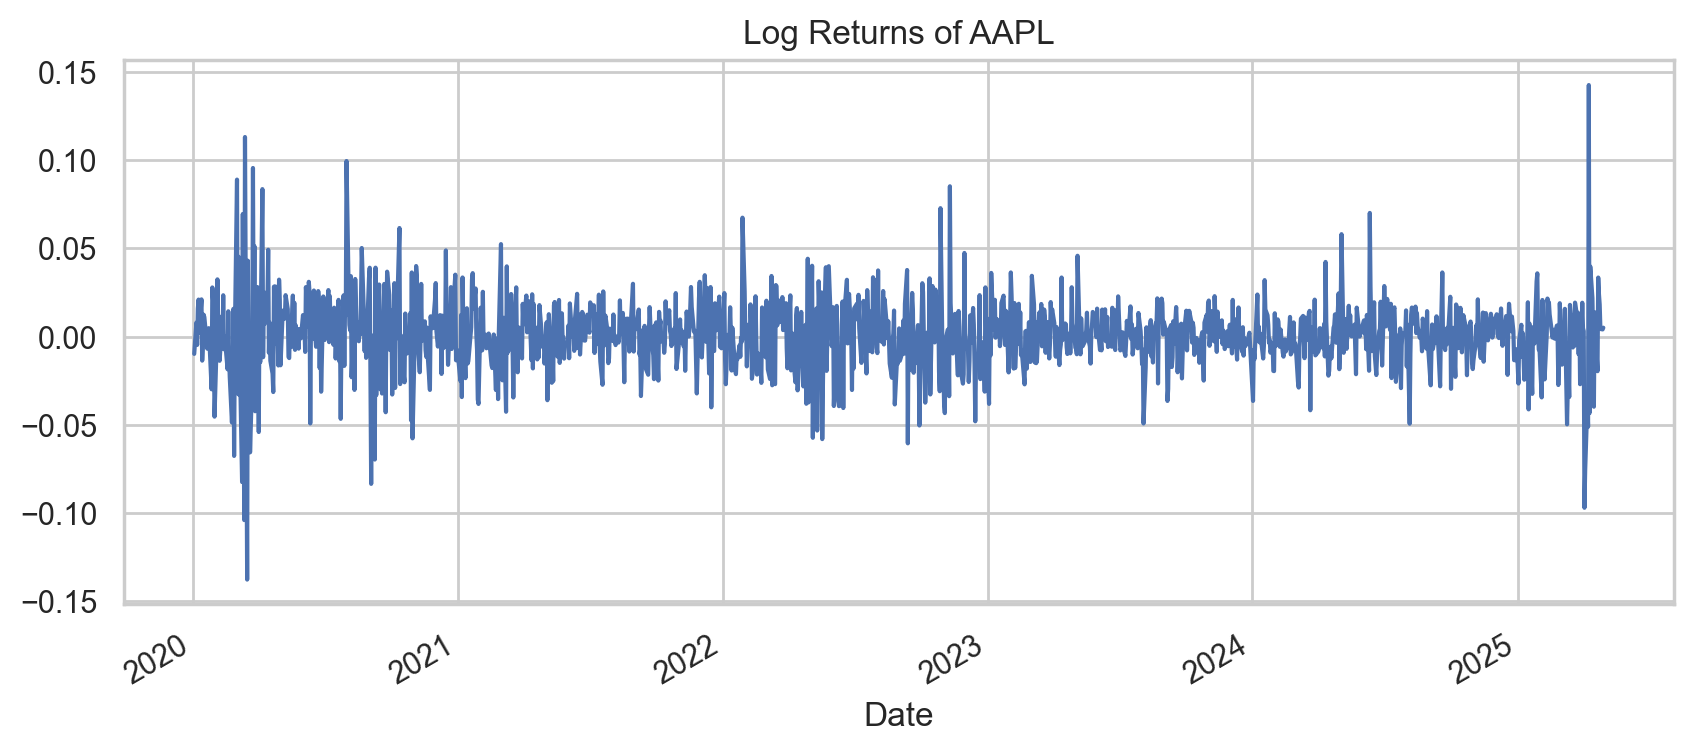

In [8]:
prices = data['Close_AAPL']
log_returns = np.log(prices / prices.shift(1)).dropna()
data['log_returns'] = log_returns

# Plot log returns
log_returns.plot(figsize=(10, 4), title="Log Returns of AAPL")

### Step 2: Estimate GBM Parameters

In [9]:
mu_hat = log_returns.mean() * 252     # Annualized drift
sigma_hat = log_returns.std() * np.sqrt(252)  # Annualized volatility

print(f"Estimated Drift (mu): {mu_hat:.4f}")
print(f"Estimated Volatility (sigma): {sigma_hat:.4f}")

Estimated Drift (mu): 0.2010
Estimated Volatility (sigma): 0.3272


### Step 3: Simulate with Estimated Parameters

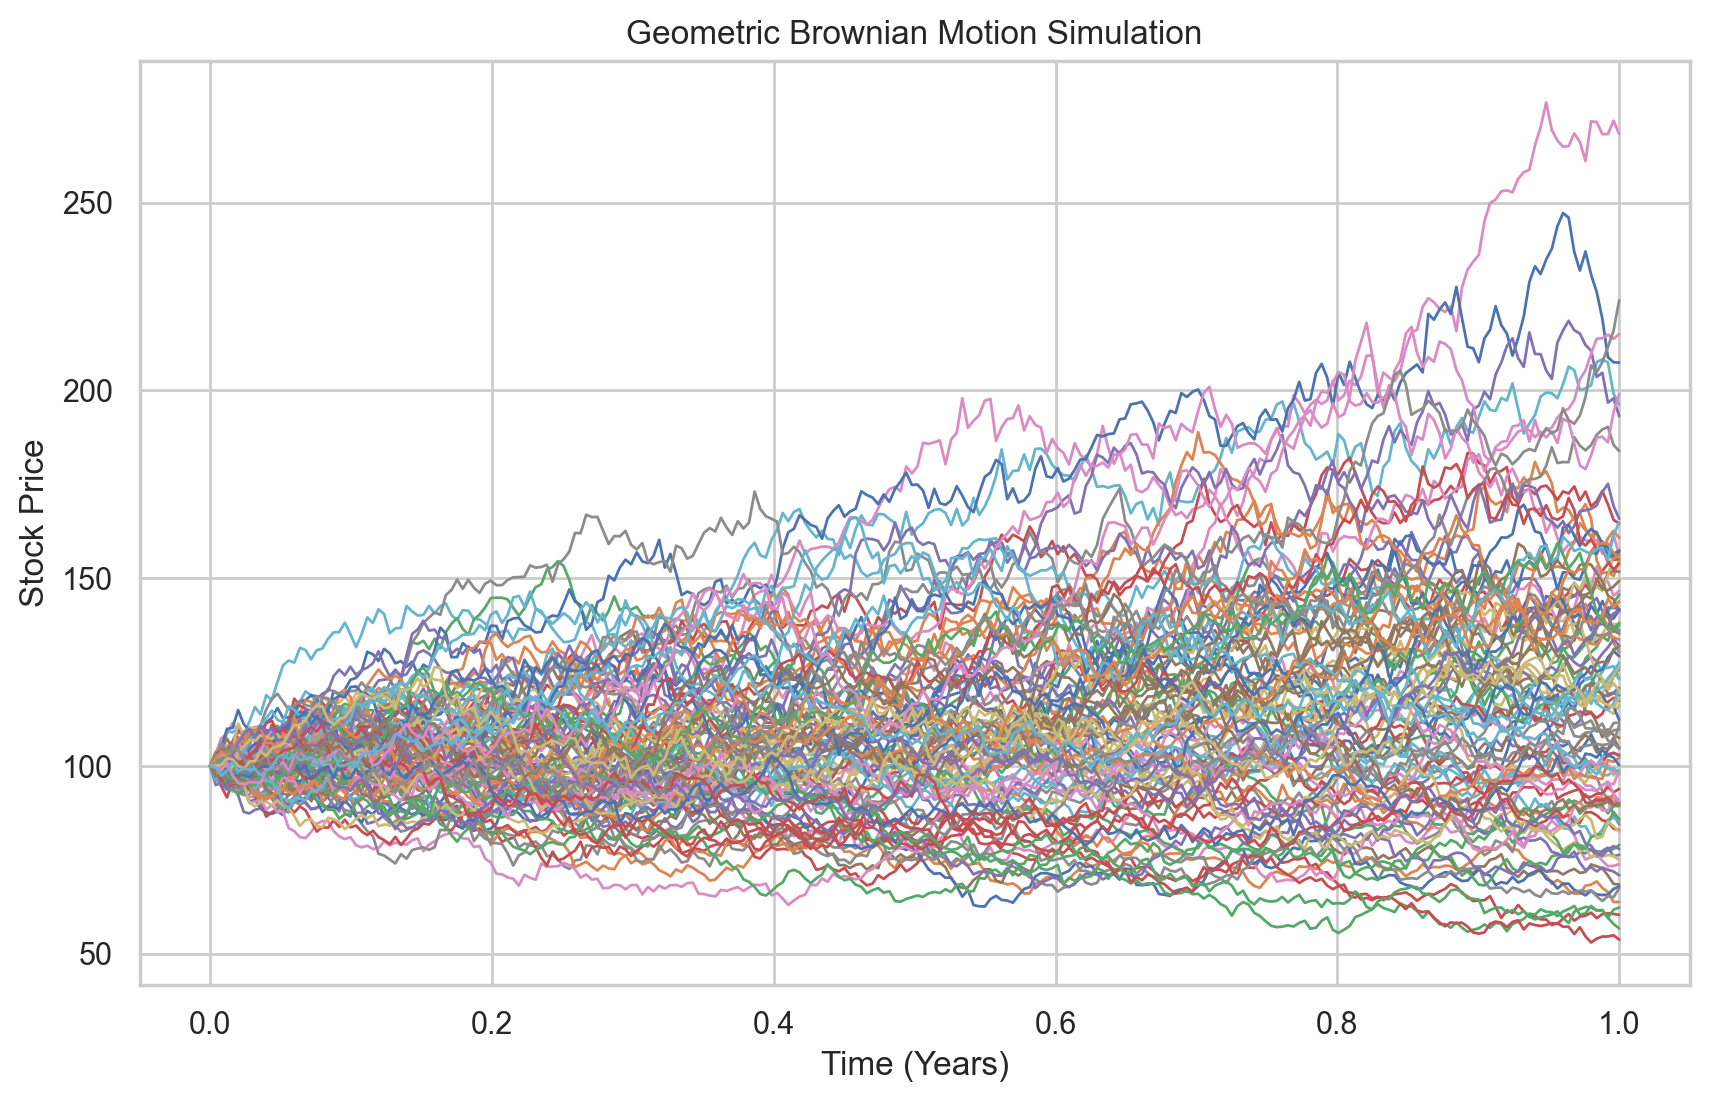

In [10]:
# Parameters
S0 = 100         # Initial stock price
mu = 0.201        # Drift
sigma = 0.32     # Volatility
T = 1.0          # Time horizon (1 year)
dt = 1/252       # Daily steps
N = int(T / dt)  # Number of steps
M = 100           # Number of paths

# Simulate GBM paths
np.random.seed(42)
t = np.linspace(0, T, N)
S = np.zeros((M, N))
S[:, 0] = S0

for i in range(1, N):
    Z = np.random.standard_normal(M)
    S[:, i] = S[:, i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Plotting
plt.figure(figsize=(10, 6))
for i in range(M):
    plt.plot(t, S[i], lw=1)
plt.title("Geometric Brownian Motion Simulation")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()

### 4. Statistics and normality test

In [11]:
mean_return = np.mean(log_returns)
std_return = np.std(log_returns)
skewness = stats.skew(log_returns)
kurtosis = stats.kurtosis(log_returns, fisher=False)  # Use Fisher=False to get the actual kurtosis (not excess)

print("\n--- Basic Statistics of Log Returns ---")
print(f"Number of observations: {len(log_returns)}")
print(f"Mean: {mean_return:.6f}")
print(f"Standard Deviation: {std_return:.6f}")
print(f"Skewness: {skewness:.6f} (Normal = 0)")
print(f"Kurtosis: {kurtosis:.6f} (Normal = 3)")
print(f"Excess Kurtosis: {kurtosis - 3:.6f}")


--- Basic Statistics of Log Returns ---
Number of observations: 1337
Mean: 0.000798
Standard Deviation: 0.020603
Skewness: 0.005721 (Normal = 0)
Kurtosis: 9.252569 (Normal = 3)
Excess Kurtosis: 6.252569


In [12]:
jb_stat, jb_pvalue = stats.jarque_bera(log_returns)
sw_stat, sw_pvalue = stats.shapiro(log_returns)
ks_stat, ks_pvalue = stats.kstest(log_returns, 'norm', args=(mean_return, std_return))

print("\n--- Normality Tests ---")
print(f"Jarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.6f}")
print(f"Shapiro-Wilk test: statistic={sw_stat:.4f}, p-value={sw_pvalue:.6f}")
print(f"Kolmogorov-Smirnov test: statistic={ks_stat:.4f}, p-value={ks_pvalue:.6f}")

if jb_pvalue < 0.05:
    print("Jarque-Bera test rejects normality at 5% significance level")
if sw_pvalue < 0.05:
    print("Shapiro-Wilk test rejects normality at 5% significance level")
if ks_pvalue < 0.05:
    print("Kolmogorov-Smirnov test rejects normality at 5% significance level")


--- Normality Tests ---
Jarque-Bera test: statistic=2177.9033, p-value=0.000000
Shapiro-Wilk test: statistic=0.9327, p-value=0.000000
Kolmogorov-Smirnov test: statistic=0.0770, p-value=0.000000
Jarque-Bera test rejects normality at 5% significance level
Shapiro-Wilk test rejects normality at 5% significance level
Kolmogorov-Smirnov test rejects normality at 5% significance level


In [13]:
# Test for ARCH effects (volatility clustering)
arch_test = het_arch(log_returns)

print("\n--- ARCH Test for Volatility Clustering ---")
print(f"LM test statistic: {arch_test[0]:.4f}")
print(f"LM test p-value: {arch_test[1]:.6f}")
print(f"F test statistic: {arch_test[2]:.4f}")
print(f"F test p-value: {arch_test[3]:.6f}")

if arch_test[1] < 0.05:
    print("ARCH effects detected (rejects constant volatility at 5% significance level)")


--- ARCH Test for Volatility Clustering ---
LM test statistic: 221.2437
LM test p-value: 0.000000
F test statistic: 26.3310
F test p-value: 0.000000
ARCH effects detected (rejects constant volatility at 5% significance level)


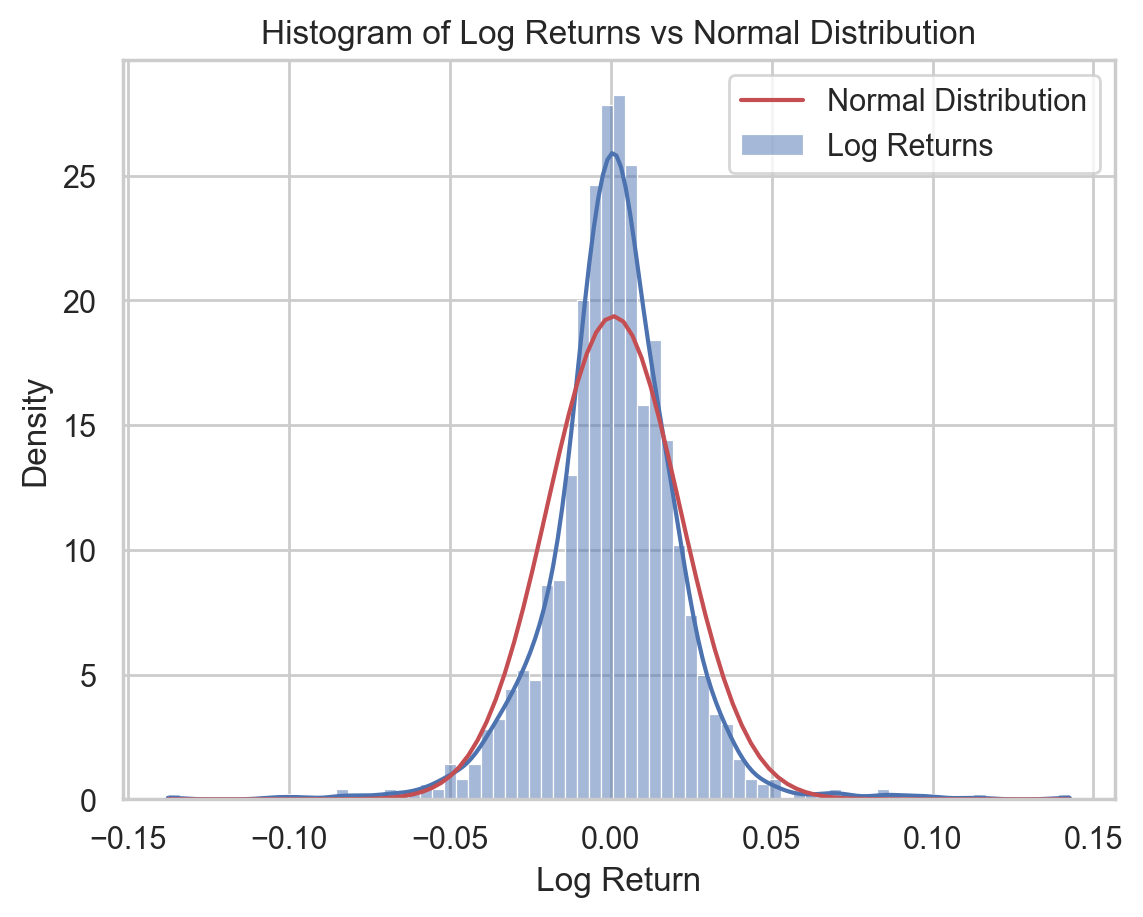

In [14]:
# Histogram with normal distribution overlay
sns.histplot(log_returns, kde=True, stat="density", label="Log Returns")
x = np.linspace(min(log_returns), max(log_returns), 100)
plt.plot(x, stats.norm.pdf(x, mean_return, std_return), 'r-', label='Normal Distribution')
plt.title('Histogram of Log Returns vs Normal Distribution')
plt.xlabel('Log Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)

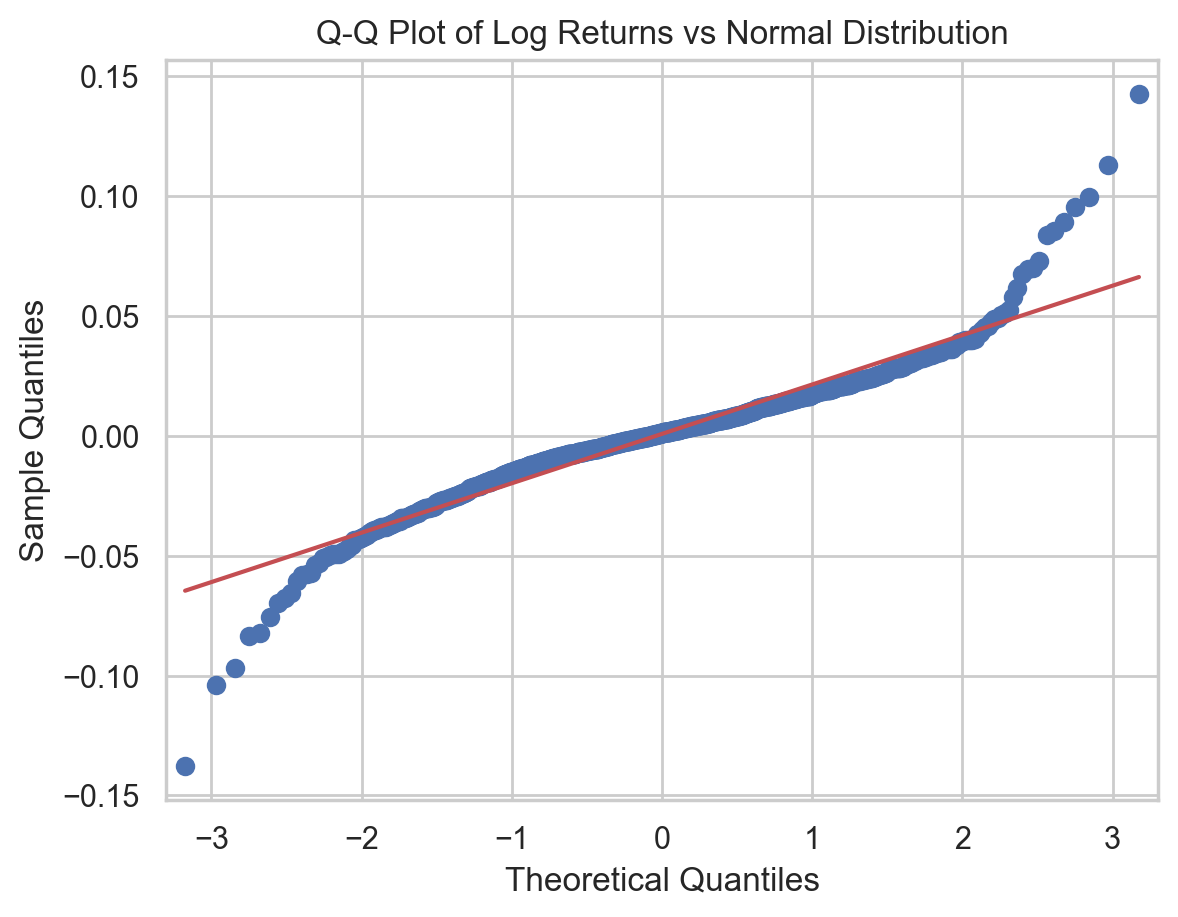

In [15]:
qqplot(log_returns, line='s', ax=plt.gca())
plt.title('Q-Q Plot of Log Returns vs Normal Distribution')
plt.grid(True)

In [16]:
# Autocorrelation of returns and squared returns
acf_vals = acf(log_returns, nlags=20, fft=False)  # fft=True is faster for large series
acf_vals_sqr = acf(log_returns **2, nlags=20, fft=False)  # fft=True is faster for large series

# Convert to Series (optional, but useful for labeling lags)
acf_returns = pd.Series(acf_vals[1:], index=range(1, 21))  # Skip lag 0
acf_squared = pd.Series(acf_vals_sqr[1:], index=range(1, 21))  # Skip lag 0

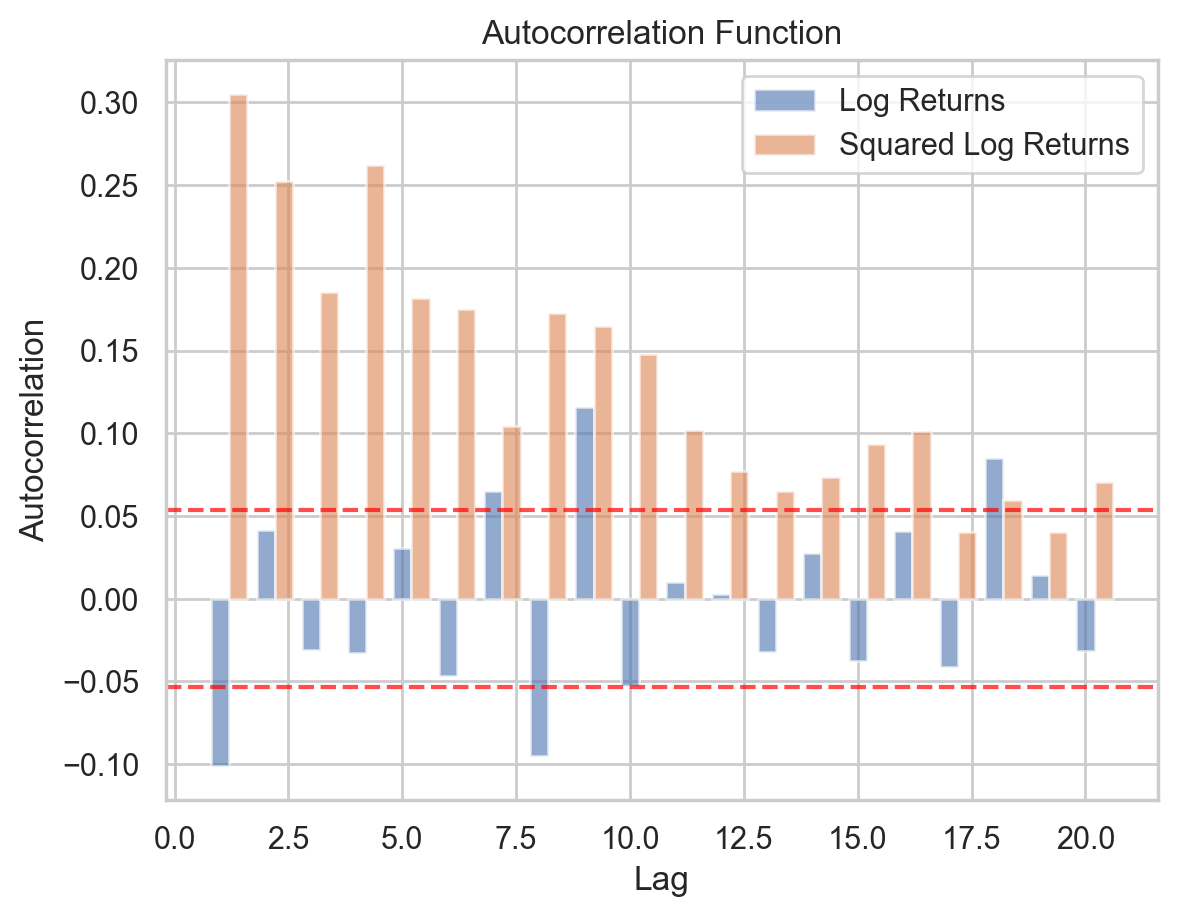

In [17]:
plt.bar(range(1, 21), acf_returns, width=0.4, label='Log Returns', alpha=0.6)
plt.bar([x + 0.4 for x in range(1, 21)], acf_squared, width=0.4, label='Squared Log Returns', alpha=0.6)
plt.axhline(y=1.96 / np.sqrt(len(log_returns)), linestyle='--', color='red', alpha=0.7)
plt.axhline(y=-1.96 / np.sqrt(len(log_returns)), linestyle='--', color='red', alpha=0.7)
plt.title('Autocorrelation Function')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)